In [26]:
import sys
import subprocess
import json
import os
import matplotlib.pyplot as plt
from functools import reduce


sys.path.append(os.path.abspath("../generation"))
import generate
from parseRePEAT import *

In [27]:
def plot_atf(segments, label, color, eatfs, fig, axs):
    line = None
    for (x0, x1, y0, y1) in segments:
        if x0 == "-inf" and x1 != "inf" and y1 != "inf":
            axs[0].hlines(float(y1), 0, float(x1), colors=color)
        line, = axs[0].plot([float(x0), float(x1)], [float(y0), float(y1)], color=color)
    line.set_label(label) if line is not None else None

    for (zeta, alpha, beta, delta, gammas) in list(eatfs.values())[0]:
        min_gammas = [float(gamma[0]) for gamma in gammas]
        min_gamma = sum(min_gammas)

        length_edge = float(beta)-float(alpha)
        max_gammas = [min(float(gamma[1]), length_edge + float(gamma[0])) for gamma in gammas]
        max_gamma = sum(max_gammas)
        axs[1].plot([float(alpha), float(beta)], [min_gamma, max_gamma], color=color)
        # axs[1].plot([float(alpha), float(beta)], [min_gammas, max_gammas], color=color)

        print(f"{alpha}, {beta}, {gammas}, {min_gamma} - {max_gamma}")

def generate_intervals(max_buffer, use_recovery_time, layout, scenario, agent, agent_speed, move, fig, axs, color, label=None):
    # Generate intervals
    generate.time_safe_intervals_and_write(layout, scenario, agent["trainNumber"], agent_speed, "output", max_buffer, use_recovery_time)
    # generate.time_safe_intervals_and_write(layout, scenario, -1, 15, "output", max_buffer, use_recovery_time)
    # start = "r-n3_2" if agent["trainNumber"] == 1 else "t-n3_1"
    start = "r-n3_2"
    timeout = 10
    try:
        # proc = subprocess.run(["atsipp.exe", "--start", start, "--goal", "r-14", "--edgegraph", "output", "--search", "repeat", "--startTime", str(move["startTime"])], timeout=20, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
        proc = subprocess.run(["Y:/Uni/Thesis/executable/atsipp.exe", "--start", start, "--goal", "r-14", "--edgegraph", "output", "--search", "repeat", "--startTime", str(move["startTime"])], timeout=timeout, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

    except subprocess.TimeoutExpired:
        print(f'Timeout for repeat ({timeout}s) expired')
        return
    repeat_output = str(proc.stdout).split("'")[1].rsplit("\\r\\n")

    # If the run was successful
    if int(proc.returncode) == 0:
        metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
        # print(f"eats: {eatfs}")
        # print(f"cats: {catf}")
        label = label if label else f"{max_buffer} seconds buffer time"
        plot_atf(catf, label, color, eatfs, fig, axs)

50, 2138.58, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
2138.58, 2160.75, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
2160.75, 2164.45, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
2164.45, 2191.62, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '23.4098', '0']], 0.0 - 23.4098
2191.62, 2195.32, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['23.4098', '27.1135', '0']], 23.4098 - 27.109800000000273
2195.32, 2791.6, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['27.1135', '623.389', '0']], 27.1135 - 623.389
2749.61, 3325.85, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
3325.85, 3344.87, [['0', '0', '0'], ['0', '0', '0'], ['0', '15.316', '0'], ['0', '0', '0']], 0.0 - 15.316
3344.87, 3346.72, [['0', '0', '0'], ['0', '0', '0'], ['15.316', '17.1679', '0'], ['0', '0', '0']], 15.316 - 17.16599999999991
3346.72, 3349.23, [['0', '0

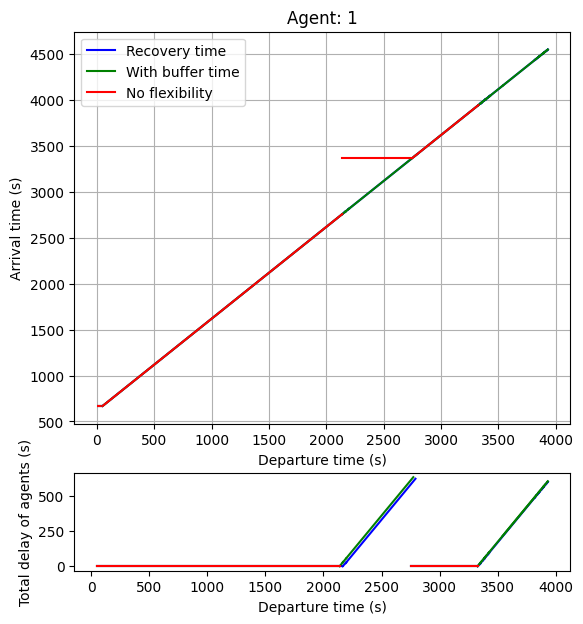

3500, 3690.37, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
3500, 3690.37, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
3500, 3690.37, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0


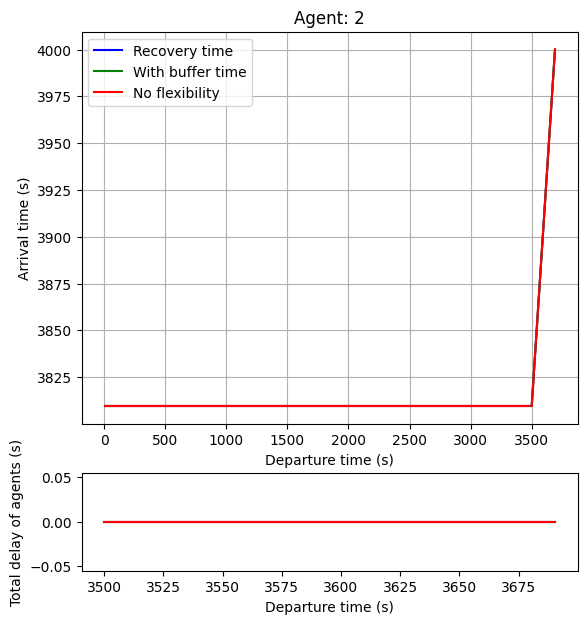

2200, 3325.85, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0']], 0.0 - 0.0
3325.85, 3344.87, [['0', '0', '0'], ['0', '0', '0'], ['0', '15.316', '0']], 0.0 - 15.316
3344.87, 3346.72, [['0', '0', '0'], ['0', '0', '0'], ['15.316', '17.1679', '0']], 15.316 - 17.16599999999991
3346.72, 3349.23, [['0', '0', '0'], ['0', '0', '0'], ['17.1679', '19.6738', '0']], 17.1679 - 19.6738
3349.23, 3351.08, [['0', '0', '0'], ['0', '0', '0'], ['19.6738', '21.5257', '0']], 19.6738 - 21.52379999999991
3351.08, 3352.46, [['0', '0', '0'], ['0', '0', '0'], ['21.5257', '22.9086', '0']], 21.5257 - 22.90570000000011
3352.46, 3371.48, [['0', '0', '0'], ['0', '0', '0'], ['22.9086', '41.9283', '0']], 22.9086 - 41.9283
3371.48, 3373.33, [['0', '0', '0'], ['0', '0', '0'], ['41.9283', '43.7802', '0']], 41.9283 - 43.77829999999991
3373.33, 3383.25, [['0', '0', '0'], ['0', '0', '0'], ['43.7802', '53.6935', '0']], 43.7802 - 53.6935
3383.25, 3385.1, [['0', '0', '0'], ['0', '0', '0'], ['53.6935', '55.5454', '0']], 53.693

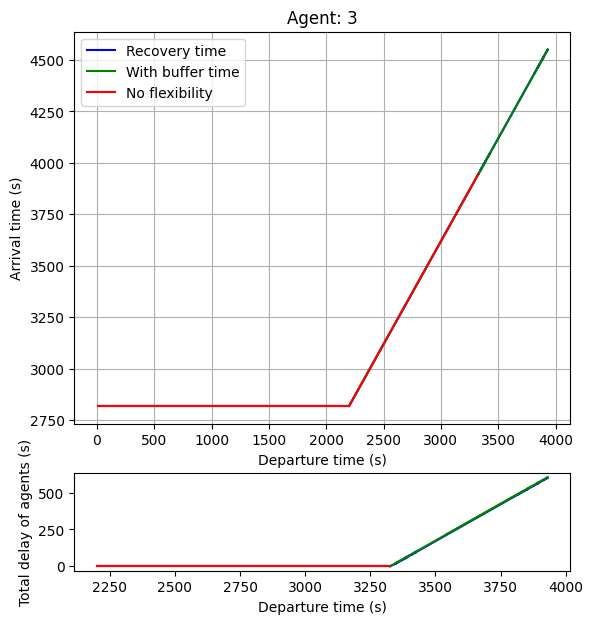

In [28]:
# Run RePeAT to get multiple plans
# scenario = "../data/single_track/scenario_following.json"
scenario = "../data/single_track/scenario_following.json"
layout =   "../data/single_track/woho.json"

scenario_data = json.load(open(scenario))
train_types = {x["name"]: x for x in scenario_data["types"]}
for agent in scenario_data['trains']:
    # Get the global end time of scenario
    scenario_end_time = 0
    for i in range(len(agent["movements"])):
        move = agent["movements"][i]
        if 2 * move["endTime"] > scenario_end_time:
            scenario_end_time = 2 * move["endTime"]
    agent_speed = train_types[agent["trainUnitTypes"][0]]["speed"] * 1.09
    # agent_speed = 60
    for move in agent["movements"]:
        fig, axs = plt.subplots(2, gridspec_kw={"height_ratios": [4, 1]})


        generate_intervals(float("inf"), True, layout, scenario, agent, agent_speed, move, fig, axs, color="blue", label="Recovery time")
        #
        generate_intervals(float("inf"), False, layout, scenario, agent, agent_speed, move, fig, axs, color="green", label="With buffer time")
        # Difference
        # generate_intervals(120, True, layout, scenario, agent, agent_speed, move, fig, axs, color="green")
        # generate_intervals(1000, layout, scenario, agent, agent_speed, move, fig, axs, color="blue")

        # baseline
        generate_intervals(0, False, layout, scenario, agent, agent_speed, move, fig, axs, color="red", label="No flexibility")

        title = f"Agent: {agent['trainNumber']}"
        axs[0].set_xlabel("Departure time (s)")
        axs[1].set_xlabel("Departure time (s)")
        axs[0].set_ylabel("Arrival time (s)")
        axs[1].set_ylabel("Total delay of agents (s)")
        axs[0].set_title(title)
        axs[0].legend()
        axs[0].grid()
        fig.set_figheight(7)
        plt.savefig(f"figures/atf_{agent['trainNumber']}")
        plt.show()

